In [2]:
# import libraries
import pandas as pd
import numpy as np
from label_functions import *
from functions import *
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.tree import plot_tree

# import data
event_log = import_xes("data/Hospital_log.xes.gz")

parsing log, completed traces ::   0%|          | 0/1143 [00:00<?, ?it/s]

In [11]:
all_traces = pd.read_csv("data/test_set_all_prefixes.csv")

In [ ]:
# export all prefixes

# set parameters when not using test set
prefix_max_len = 21 # maximum length of prefixes
prefix_steps = 5 # number of steps to skip when extracting prefixes

all_traces = event_log.groupby('case:concept:name')['Activity code'].apply(list)
all_traces = all_traces.apply(lambda x: prefix_extraction(x, prefix_max_len, prefix_steps))
all_traces = all_traces.explode()

In [ ]:
# set parameters
n_validation = 100 # number of validation runs (LOOCV)
n_most_similar = 100 # number of most similar historic traces to include
X_cols = ['case:Diagnosis code', 'case:Treatment code']
lf = label_function_1

# get prefixes
if use_testset:
    all_traces = pd.read_csv("data/test_set_all_prefixes.csv")
else:


# get a label function map
lf_map = get_lf_map(event_log, lf)

# Train model with leave-one-out cross-validation
df_predictions = []
for i in range(n_validation):   
    running_trace = all_traces.sample(1)
    historic_traces = all_traces.drop(running_trace.index)

    running_trace_length = len(running_trace.iloc[0])

    # calculate similarity scores
    similarity_scores = get_similarity(running_trace, historic_traces, similarity=True)

    # get n most similar traces
    sorted_similar_traces = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
    most_similar_traces = sorted_similar_traces[:n_most_similar]

    # calculate average similarity score
    avg_similarity = np.mean([x[1] for x in most_similar_traces])

    # get label function
    similar_traces_list = [x[0] for x in most_similar_traces]

    # get y_train and y_test
    y_train = [lf_map[trace] for trace in similar_traces_list]
    y_test = int(lf_map[running_trace.index[0]])

    # train model
    clf, le_dict = train_model(X_cols, event_log, similar_traces_list, lf_map)

    # predict label
    y_pred, y_prob = predict_label(X_cols, event_log, running_trace, clf, le_dict)

    results = [running_trace_length, avg_similarity, sum(y_train), y_test, y_pred, y_prob]
    df_predictions.append(results)

col_names = ['trace_len', 'avg_similarity', 'pos_y_train', 'y_test', 'y_pred', 'y_prob']
df_predictions = pd.DataFrame(df_predictions, columns=col_names)

# accuracy from most common label
acc1 = max(lf_map.mean(), 1-lf_map.mean())

# accuracy from most common label among similar traces
acc2 = ((df_predictions['pos_y_train'] > n_most_similar/2) == df_predictions['y_test']).mean()

# accuracy from decision tree model
acc3 = (df_predictions['y_test'] == df_predictions['y_pred']).mean()

# print accuracies
print(f'Accuracy from most common label: {acc1:.3f}')
print(f'Accuracy from most common label among similar traces: {acc2:.3f}')
print(f'Accuracy from decision tree model: {acc3:.3f}')

Accuracy from most common label: 0.598
Accuracy from most common label among similar traces: 0.690
Accuracy from decision tree model: 0.720


In [5]:
threshold = 0.6

df_predictions[df_predictions['y_prob'] > threshold]

,trace_len,avg_similarity,pos_y_train,y_test,y_pred,y_prob
1,1,0.210106,52,0,1,1.000000
2,16,0.761905,28,1,0,0.622222
3,6,0.246507,79,1,1,0.792208
4,21,0.960476,24,1,0,0.625000
5,16,0.217083,56,1,1,0.692308
...,...,...,...,...,...,...
92,1,0.133225,86,1,1,1.000000
93,1,0.306737,84,1,1,0.875000
97,21,0.174762,68,1,1,0.761905
98,21,0.959048,28,0,0,1.000000


F1 score: 0.686


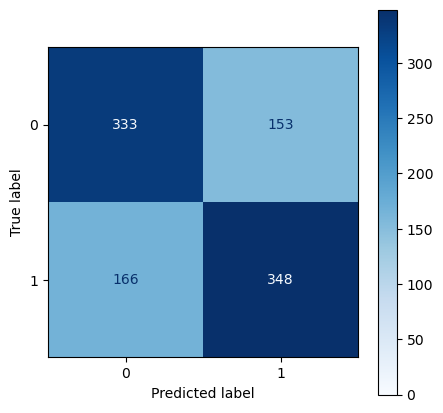

In [ ]:
# confusion matrix figure

f1 = f1_score(df_predictions['y_test'], df_predictions['y_pred'])
print(f'F1 score: {f1:.3f}')

cm = confusion_matrix(df_predictions['y_test'], df_predictions['y_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap='Blues')

# decrease figure size
plt.gcf().set_size_inches(5, 5)
disp.ax_.get_images()[0].set_clim(0, cm.max());

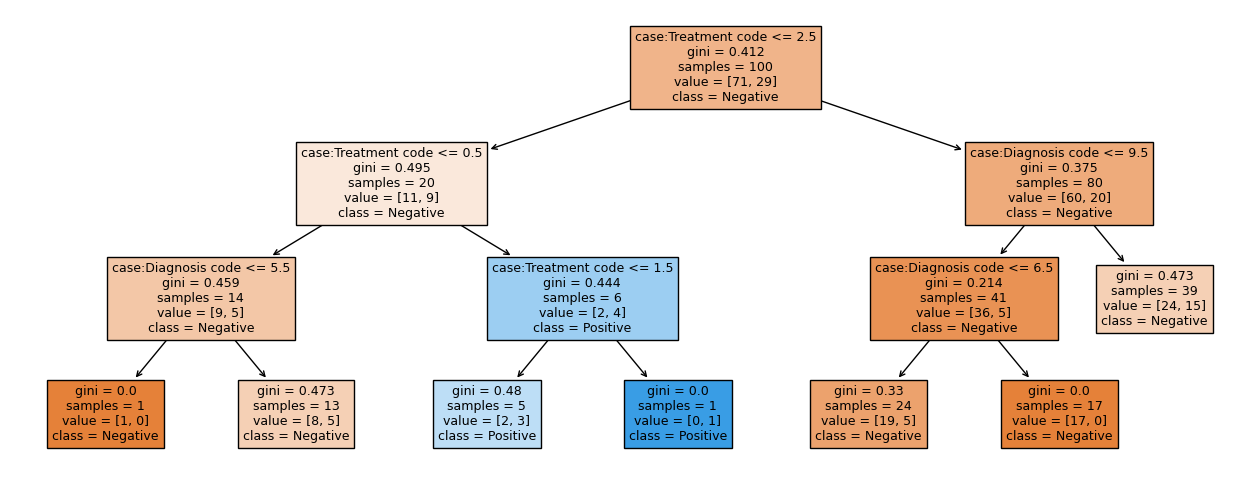

In [ ]:
# plot last decision tree
plt.figure(figsize=(16,6))
plot_tree(clf, feature_names=X_cols, filled=True, class_names=['Negative', 'Positive']);

In [12]:
# percentages of non-missing values for each X column
X_cols = ['case:Diagnosis code', 'case:Treatment code']
for col in X_cols:
    print(col)
    x = event_log.groupby('case:concept:name')[col].last().notna().sum() / event_log['case:concept:name'].nunique()
    print(x)

case:Diagnosis code
0.6019247594050744
case:Treatment code
0.5914260717410323


### Visualizations

In [ ]:
import editdistance

def get_similar_traces(running_trace, traces, threshold=40):
    
    # convert running trace to list if it is a series
    if isinstance(running_trace, pd.Series):
        running_trace = running_trace.iloc[0]
    
    # find similar traces
    similar_traces = []
    for case, activities in traces.items():
        distance = editdistance.eval(running_trace, activities)
        if distance <= threshold:
            similar_traces.append((case, distance))
    return dict(similar_traces)

In [123]:
df_list = []
for th in range(0, 205, 10):
    n_similar_traces = []
    for _ in range(50):
        running_trace = all_traces.sample(1)
        historic_traces = all_traces.drop(running_trace.index)
        similar_traces = get_similar_traces(running_trace, historic_traces, threshold=th)
        n_similar_traces.append(len(similar_traces))
    mean_similar_traces = sum(n_similar_traces) / len(n_similar_traces)
    min_similar_traces = min(n_similar_traces)
    df_list.append([th, mean_similar_traces, min_similar_traces])

df_th = pd.DataFrame(df_list, columns=['Threshold', 'Mean similar traces', 'Min similar traces'])

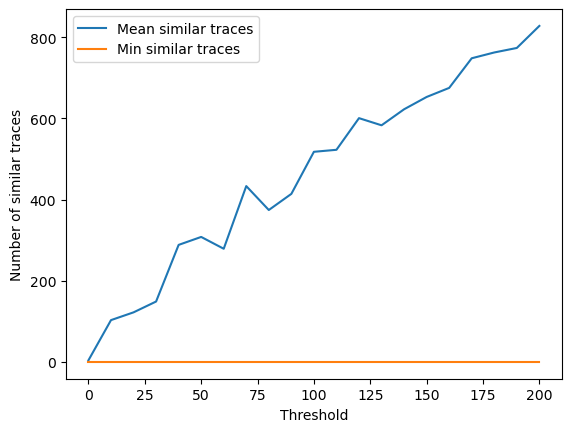

In [124]:
# plot threshold and number of similar traces
import matplotlib.pyplot as plt

plt.plot(df_th['Threshold'], df_th['Mean similar traces'], label='Mean similar traces')
plt.plot(df_th['Threshold'], df_th['Min similar traces'], label='Min similar traces')
plt.xlabel('Threshold')
plt.ylabel('Number of similar traces')
plt.legend();